# Q2. (20 points) Question carry forwarded from assignment-2.
Use the Admission dataset to perform the following task.  
Dataset can be downloaded from http://preon.iiit.ac.in/~sanjoy_chowdhury/AdmissionDataset.zip

In [1]:
import pandas as pd
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns
from utils import train_test_split


In [2]:
df_orig = pd.read_csv("data/admission/data.csv")
df_orig.head()
df_orig.drop(["Serial No."], axis=1, inplace=True)

In [3]:
df_orig.describe()


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,316.542222,107.162222,3.126667,3.361111,3.468889,8.577600,0.553333,0.720889
std,11.335705,6.023554,1.140254,0.993374,0.919432,0.599454,0.497701,0.141398
min,290.000000,92.000000,1.000000,1.000000,1.000000,7.200000,0.000000,0.340000
25%,308.250000,103.000000,2.000000,2.500000,3.000000,8.122500,0.000000,0.630000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.560000,1.000000,0.720000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.040000,1.000000,0.820000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [4]:
def prob_to_label(df, threshold):
    """Converts the output feature from continuous values to discrete labels."""
    df["label"] = [1 if chance >= 0.5 else 0 for chance in df['Chance of Admit ']]
    return df.drop(['Chance of Admit '], axis=1, errors='ignore')

df = prob_to_label(df_orig, 0.5)

In [5]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,label
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,316.542222,107.162222,3.126667,3.361111,3.468889,8.577600,0.553333,0.922222
std,11.335705,6.023554,1.140254,0.993374,0.919432,0.599454,0.497701,0.268120
min,290.000000,92.000000,1.000000,1.000000,1.000000,7.200000,0.000000,0.000000
25%,308.250000,103.000000,2.000000,2.500000,3.000000,8.122500,0.000000,1.000000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.560000,1.000000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.040000,1.000000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,1.000000


# Part-1: (10 points) Implement logistic regression model to predict if the student will get admit.

In [6]:
class LogisticRegressionModel:
    def __init__(self, learning_rate, number_of_iterations, threshold=0.5):
        self.alpha = learning_rate
        self.num_iters = number_of_iterations
        self.threshold = threshold
        
    
    def fit(self, X, y):
        n = len(X.columns)  # number of features without x0 column
        
        # save the mean and std used to normalize so that we can reuse them while predicting
        self.mean = X.mean()
        self.std = X.std()
        
        # normalize feature set X
        X = self._normalize(X)

        # dim(X) = m x n
        X = self._prefix_ones_column(X)
        
        # initialize theta with some values
        self.theta = np.zeros((n+1, 1)) ## dim(theta) = n+1 x 1 

        # dim(X) = m x n+1
        self._gradient_descent(X.values, y.values)
        
    
    def predict_probability(self, X):
        X = self._normalize(X)
        # dim(X) = m x n
        # add a column x0 containing all Ones
        X = self._prefix_ones_column(X)    
        # dim(X) = m x n+1
        # dim(theta) = n+1 x 1
        
        y_prob = sigmoid(np.dot(X.values, self.theta))
        
        return y_prob
    
        
    def predict(self, X):
        y_prob = self.predict_probability(X)
        
        y_pred = [1 if prob>=self.threshold else 0 for prob in y_prob]
        y_pred_df = pd.DataFrame(data=y_pred, index=X.index)
        
        return y_pred_df
    
    
    def _gradient_descent(self, X, y):
        """ 
            theta = n+1 x 1
            alpha = scalar
            X = m x (n+1)
            h = m x 1
            y = m x 1
            -----------------------------------------
            theta = theta - (alpha/m) * X.T * (h - y)
        """

        m = len(X) # number of samples
        
        for it in range(self.num_iters):
            h = sigmoid(np.dot(X, self.theta)) # dim(h) = m x 1
            
            error = h - y # dim(error) = m x 1
            self.theta = self.theta - (self.alpha * np.dot(X.T, error) / m)
       
    
    def _prefix_ones_column(self, df):
        # add a column x0 containing all Ones
        df = df.assign(x0=pd.Series(np.ones(len(df))).values)

        # make x0 the first column
        columns = df.columns.tolist()
        columns.remove('x0')
        df = df[['x0'] + columns]
        return df
    
    def _normalize(self, df):
        df = (df - self.mean) / self.std
        return df
        


def sigmoid(z):
    """
    Sigmoid function :
        g(z) = 1 / (1 + e^(-z))
        -z can be performed in z is a numpy array 
        else we need to do: 1 + np.exp(np.negative(z))
    """
    return 1 / (1 + np.exp(-z))


In [7]:
model = LogisticRegressionModel(learning_rate=0.01, number_of_iterations=500)


X = df.drop(["label"], axis=1)
y = df[["label"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2,random_state=100) 

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
y_pred.describe()

,0
count,90.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [9]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
print("Accuracy:", accuracy_score(y_pred=y_pred, y_true=y_test))
print("Precision:", precision_score(y_pred=y_pred, y_true=y_test))
print("Recall:", recall_score(y_pred=y_pred, y_true=y_test))

Accuracy: 0.9333333333333333
Precision: 0.9333333333333333
Recall: 1.0


# Part-2: (5 points) Compare the performances of logistic regression model with KNN model on the Admission dataset.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training set
knn_model.fit(X_train, y_train.values.reshape(len(y_train),))

# Predict Output
y_pred_knn = knn_model.predict(X_test)

# Report accuracy
print("KNN Accuracy:", accuracy_score(y_pred=y_pred_knn, y_true=y_test))
# accuracy_score(y_true=y_test.values.reshape(len(y_test),), y_pred=y_test.values.reshape(len(y_test),))

KNN Accuracy: 0.9555555555555556


# Part-3: (5 points) 
- Plot a graph explaining the co-relation between threshold value vs precision and recall.
- Report the criteria one should use while deciding the threshold value. 
- Explain the reason behind your choice of threshold in your model.

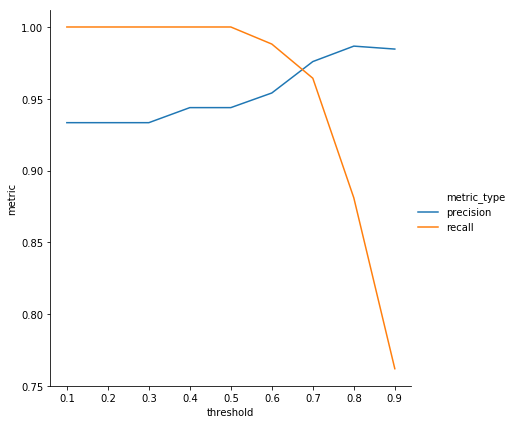

In [11]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

data = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    model = LogisticRegressionModel(0.1, 500, threshold=threshold)

    df = prob_to_label(df_orig, threshold)    
    
    X = df.drop(["label"], axis=1)
    y = df[["label"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2, random_state=1) 

    model.fit(X_train,y_train)  
    y_pred = model.predict(X_test)
    precision = precision_score(y_pred=y_pred, y_true=y_test)
    recall = recall_score(y_pred=y_pred, y_true=y_test)

    data.append((threshold, precision,"precision"))
    data.append((threshold, recall,"recall"))
    
plotdf = pd.DataFrame(data, index=range(len(data)), columns=["threshold", "metric", "metric_type"])
sns.relplot(x="threshold", y="metric", kind="line", hue="metric_type", data=plotdf, height=6)


# Q3. (10 points) Implement logistic regression using One vs All and One vs One approaches.
Use the following dataset http://preon.iiit.ac.in/~sanjoy_chowdhury/wine-quality.zip for completing the task.  
Report your observations and accuracy of the model.

In [12]:
df_orig = pd.read_csv("data/wine-quality/data.csv", sep=';',skiprows=1,
                 names=["fixed acidity", "volatile acidity", "citric acid", "residual sugar","chlorides",
                        "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol",
                        "quality"])
df_orig.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.2,0.25,0.34,1.2,0.026,31.0,93.0,0.9916,2.93,0.37,11.3,7


In [13]:
df_orig.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000
mean,6.852189,0.278565,0.333786,6.355377,0.045758,35.307849,138.007827,0.994001,3.187675,0.488185,10.513036,5.873866
std,0.838939,0.100747,0.121491,4.981474,0.022044,17.024667,41.854932,0.002909,0.150323,0.113913,1.226730,0.882972
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.200000,0.043000,34.000000,134.000000,0.993700,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.800000,0.050000,46.000000,167.000000,0.996040,3.280000,0.542500,11.400000,6.000000
max,14.200000,1.100000,1.660000,31.600000,0.346000,289.000000,440.000000,1.010300,3.810000,1.080000,14.200000,9.000000


In [14]:
quality_scores = np.unique(df_orig["quality"].values)

In [15]:
# X = df.drop(["quality"], axis=1)
# y = df[["quality"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# One-vs-All

In [16]:
def convert_to_binary_class(df, true_class):
    df["label"] = [1 if quality==true_class else 0 for quality in df['quality']]
    return df.drop(['quality'], axis=1, errors='ignore')


In [17]:
num_labels = len(quality_scores)
num_features = len(df_orig.columns) # -1 for label column and +1 for x0 column (column of ones)

X = df_orig.drop(["quality"], axis=1)
y = df_orig[["quality"]]

# split to train validate 
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)

# dim(label_probs) = m x num_unique_labels + 1(for highest probability label)
label_probs = np.zeros(shape=(len(y_test), num_labels + 1))

for i, quality in enumerate(quality_scores):
    # convert multiclass to binary class
    y_train_binary = convert_to_binary_class(y_train.copy(), quality)

    model = LogisticRegressionModel(learning_rate=0.01, number_of_iterations=500)

    model.fit(X_train, y_train_binary)
    y_prob = model.predict_probability(X_test)
    label_probs[:,i] = y_prob.ravel()

for row in range(len(label_probs)):
    # set label to the one with highest probability
    label_probs[row, -1] = quality_scores[label_probs[row].argmax()]


y_pred = label_probs[:,-1]
print(accuracy_score(y_pred=y_pred, y_true=y_test))

0.5147392290249433


# One-vs-One